In [5]:
import pandas as pd
from sklearn.model_selection import KFold
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
eur_usd=pd.read_csv("eurusd.csv")
print(eur_usd)

            Date   Close    High     Low    Open
0     2001-08-01  0.8810  0.8831  0.8748  0.8751
1     2001-08-02  0.8828  0.8841  0.8779  0.8811
2     2001-08-03  0.8840  0.8876  0.8772  0.8830
3     2001-08-06  0.8818  0.8832  0.8780  0.8830
4     2001-08-07  0.8771  0.8824  0.8744  0.8816
...          ...     ...     ...     ...     ...
4996  2019-09-17  1.1071  1.1075  1.0989  1.1005
4997  2019-09-18  1.1031  1.1076  1.1012  1.1071
4998  2019-09-19  1.1045  1.1074  1.1021  1.1031
4999  2019-09-20  1.1017  1.1068  1.0995  1.1045
5000  2019-09-21  1.1017  1.1022  1.1000  1.1003

[5001 rows x 5 columns]


In [7]:
eur_usd.head()

,Date,Close,High,Low,Open
0,2001-08-01,0.8810,0.8831,0.8748,0.8751
1,2001-08-02,0.8828,0.8841,0.8779,0.8811
2,2001-08-03,0.8840,0.8876,0.8772,0.8830
3,2001-08-06,0.8818,0.8832,0.8780,0.8830
4,2001-08-07,0.8771,0.8824,0.8744,0.8816


In [8]:
def create_features(fx_data):
    
    fx_data=fx_data.sort_values('Date')
    
    #Features
    fx_data['High-low']=fx_data["High"]-fx_data["Low"]
    fx_data['pct_change']=fx_data['Close'].pct_change()
    fx_data['ret_5']=fx_data['pct_change'].rolling(5).mean()
    
    #Rsi Indicator
    close=fx_data["Close"]
    delta=close.diff()
    delta=delta[1:]
    up,down=delta.copy(),delta.copy()
    up[up<0]=0
    down[down>0]=0
    
    #Calculate ema
    roll_up=up.rolling(center=False,window=14).mean()
    roll_down=abs(down).rolling(center=False,window=14).mean()
    
    #Calculate rsi based on ewma
    
    RS=roll_up/roll_down
    RSI=100-(100/(1.0+RS))
    
    fx_data['RSI']=RSI
    fx_data.dropna(inplace=True)
    
    target=np.where(fx_data['Close'].shift(-1)>fx_data['Close'],1, -1)
    
    return fx_data, target
    

In [9]:
features, target=create_features(eur_usd)

In [10]:
X=features[["High-low","pct_change","ret_5","RSI"]]
y=target

In [11]:
length_to_split=int(len(features)*0.8)
X_train,X_test=X[:length_to_split],X[length_to_split:]
y_train,y_test=y[:length_to_split],y[length_to_split:]

In [12]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(3989, 4) (998, 4)
(3989,) (998,)


In [13]:
clf=tree.DecisionTreeClassifier(random_state=20)

In [14]:
model=clf.fit(X_train,y_train)

In [15]:
print(accuracy_score(y_test,model.predict(X_test),normalize=True)*100)

51.302605210420836


In [16]:
#Kfold validation approach
kf=KFold(n_splits=5,shuffle=False)
kf.split(X)

<generator object _BaseKFold.split at 0x05311BB0>

In [17]:
#Initialize the accuracy to a blank list
accuracy_model=[]
for train_index,test_index in kf.split(X):
    X_train,X_test=X.iloc[train_index],X.iloc[test_index]
    y_train,y_test=y[train_index],y[test_index]
    # Train the model
    model=clf.fit(X_train,y_train)
    accuracy_model.append(accuracy_score(y_test,model.predict(X_test),normalize=True)*100)

# Print accuacy
print(accuracy_model)

[50.50100200400801, 52.104208416833664, 48.946840521564695, 46.138415245737214, 51.25376128385155]


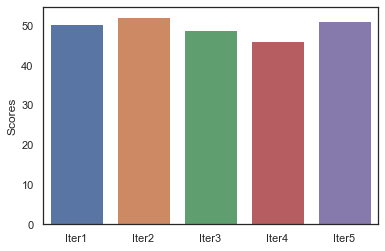

In [18]:
scores=pd.DataFrame(accuracy_model,columns=['Scores'])

sns.set(style="white",rc={"lines.linewidth":3})
sns.barplot(x= ['Iter1','Iter2','Iter3','Iter4','Iter5'],y="Scores",data=scores)
plt.show()
sns.set()